In [143]:
import pandas as pd
import numpy as np
import os 
import glob, os
from scipy import stats
from geopy.distance import great_circle
from geopy.distance import geodesic
import geopandas
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Create JANUARY - MAY 2019,2020 CitiBike Data Frame

In [2]:

#Get 2019,2020 citibike into dataframes, loop through folder, and put data frames in a list 

df_bike_list_2020=[]
for filename in glob.iglob('data/citibike/2020/**.csv', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_bike_list_2020.append(pd.read_csv(filename))
        
        
df_bike_list_2019=[]
for filename in glob.iglob('data/citibike/2019/**.csv', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_bike_list_2019.append(pd.read_csv(filename))
        


In [3]:
#create 2019,2020 citibike by concating list of dfs
bike_2020_df = pd.concat(df_bike_list_2020)
bike_2019_df = pd.concat(df_bike_list_2019)

In [4]:
#2020 citibike

print(bike_2020_df.shape)
bike_2020_df.head()

(5626535, 15)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,789,2020-01-01 00:00:55.3900,2020-01-01 00:14:05.1470,504,1 Ave & E 16 St,40.732219,-73.981656,307,Canal St & Rutgers St,40.714275,-73.989900,30326,Subscriber,1992,1
1,1541,2020-01-01 00:01:08.1020,2020-01-01 00:26:49.1780,3423,West Drive & Prospect Park West,40.661063,-73.979453,3300,Prospect Park West & 8 St,40.665147,-73.976376,17105,Customer,1969,1
2,1464,2020-01-01 00:01:42.1400,2020-01-01 00:26:07.0110,3687,E 33 St & 1 Ave,40.743227,-73.974498,259,South St & Whitehall St,40.701221,-74.012342,40177,Subscriber,1963,1
3,592,2020-01-01 00:01:45.5610,2020-01-01 00:11:38.1550,346,Bank St & Hudson St,40.736529,-74.006180,490,8 Ave & W 33 St,40.751551,-73.993934,27690,Subscriber,1980,1
4,702,2020-01-01 00:01:45.7880,2020-01-01 00:13:28.2400,372,Franklin Ave & Myrtle Ave,40.694546,-73.958014,3637,Fulton St & Waverly Ave,40.683239,-73.965996,32583,Subscriber,1982,1


In [5]:
#2019 citibike
print(bike_2019_df.shape)
bike_2019_df.head()


(6929648, 15)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,320,2019-01-01 00:01:47.4010,2019-01-01 00:07:07.5810,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.7360,2019-01-01 00:10:00.6080,519.0,Pershing Square North,40.751873,-73.977706,518.0,E 39 St & 2 Ave,40.747804,-73.973442,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.9970,2019-01-01 00:15:55.4380,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.5450,2019-01-01 00:52:22.6500,504.0,1 Ave & E 16 St,40.732219,-73.981656,3709.0,W 15 St & 6 Ave,40.738046,-73.996430,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.9450,2019-01-01 00:12:39.5020,229.0,Great Jones St,40.727434,-73.993790,503.0,E 20 St & Park Ave,40.738274,-73.987520,35379,Subscriber,1979,1


In [6]:
#Add Hyphens to bike df column names
bike_2019_df.columns= pd.Series(bike_2019_df.columns).str.replace(" ","_")
bike_2020_df.columns = pd.Series(bike_2020_df.columns).str.replace(" ","_")

In [12]:
#create time columns for bike 
bike_2019_df["DATE_TIME"] = pd.to_datetime(bike_2019_df["starttime"])
bike_2020_df["DATE_TIME"] =  pd.to_datetime(bike_2020_df["starttime"])

bike_2020_df["DATE"] =  bike_2020_df["DATE_TIME"].dt.date
bike_2019_df["DATE"] =  bike_2019_df["DATE_TIME"].dt.date


'###2020 year, month,days\n\nbike_2020_df["YEAR"] =  bike_2020_df["DATE_TIME"].dt.year\nbike_2020_df["MONTH"] =  bike_2020_df["DATE_TIME"].dt.month\nbike_2020_df["DAY"] =  bike_2020_df["DATE_TIME"].dt.day\nbike_2020_df["DATE"] =  bike_2020_df["DATE_TIME"].dt.date\nbike_2020_df["WEEK"] =  bike_2020_df["DATE_TIME"].dt.week\n\n#2019 year, month,days\nbike_2019_df["YEAR"] =  bike_2019_df["DATE_TIME"].dt.year\nbike_2019_df["MONTH"] =  bike_2019_df["DATE_TIME"].dt.month\nbike_2019_df["DAY"] =  bike_2019_df["DATE_TIME"].dt.day\nbike_2019_df["DATE"] =  bike_2019_df["DATE_TIME"].dt.date\nbike_2019_df["WEEK"] =  bike_2019_df["DATE_TIME"].dt.week\n'

# 2019 - 2020 Daily % Changes in Bike Rides

In [139]:
#Get the daily rides for 2019

bike_2019_daily = bike_2019_df.groupby(bike_2019_df.DATE_TIME.dt.date)['DATE'].count().reset_index().rename(columns={"DATE":"DAILY_RIDES"})
bike_2019_daily['MONTH_DAY']=pd.to_datetime(bike_2019_daily['DATE_TIME']).dt.strftime('%m-%d')
bike_2019_daily.rename(columns={"DAILY_RIDES":"DAILY_RIDES_19"},inplace=True)
print(bike_2019_daily.shape)

bike_2019_daily.head()

(151, 3)


,DATE_TIME,DAILY_RIDES_19,MONTH_DAY
0,2019-01-01,21962,01-01
1,2019-01-02,37797,01-02
2,2019-01-03,41676,01-03
3,2019-01-04,43922,01-04
4,2019-01-05,17432,01-05


In [131]:
#Get the daily rides for 2020
bike_2020_daily = bike_2020_df.groupby(bike_2020_df.DATE_TIME.dt.date)['DATE'].count().reset_index().rename(columns={"DATE":"DAILY_RIDES"})
bike_2020_daily.rename(columns={"DAILY_RIDES":"DAILY_RIDES_20"},inplace=True)
bike_2020_daily['MONTH_DAY']=pd.to_datetime(bike_2020_daily['DATE_TIME']).dt.strftime('%m-%d')
print(bike_2020_daily.shape)
bike_2020_daily.head()

(152, 3)


,DATE_TIME,DAILY_RIDES_20,MONTH_DAY
0,2020-01-01,18114,01-01
1,2020-01-02,41556,01-02
2,2020-01-03,31873,01-03
3,2020-01-04,29436,01-04
4,2020-01-05,27589,01-05


Index(['DATE_TIME', 'DAILY_RIDES_19'], dtype='object')

In [161]:
bike_2019_2020_daily = bike_2019_daily.merge(bike_2020_daily,suffixes=('_19','_20'),on="MONTH_DAY")

bike_2019_2020_daily_pct_diff = bike_2019_2020_daily[['DAILY_RIDES_19','DAILY_RIDES_20']].agg(pd.DataFrame.pct_change,axis="columns")

bike_2019_2020_daily_pct_diff= bike_2019_2020_daily_pct_diff.rename(columns={"DAILY_RIDES_20":"PNCT_CHANGE_19_20"})

bike_2019_2020_daily_pct_diff = pd.concat([bike_2019_2020_daily_pct_diff,bike_2019_2020_daily['MONTH_DAY']],axis=1)

In [181]:
bike_2019_2020_daily_pct_diff.head()

,DAILY_RIDES_19,PNCT_CHANGE_19_20,MONTH_DAY
0,NaN,-0.175212,01-01
1,NaN,0.099452,01-02
2,NaN,-0.235219,01-03
3,NaN,-0.329812,01-04
4,NaN,0.582664,01-05


In [222]:
#create x axis
x_axis_days =pd.to_datetime('20-'+bike_2019_2020_daily_pct_diff.MONTH_DAY,format="%y-%m-%d",yearfirst=False)
x_axis_days

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
         ...    
146   2020-05-27
147   2020-05-28
148   2020-05-29
149   2020-05-30
150   2020-05-31
Name: MONTH_DAY, Length: 151, dtype: datetime64[ns]

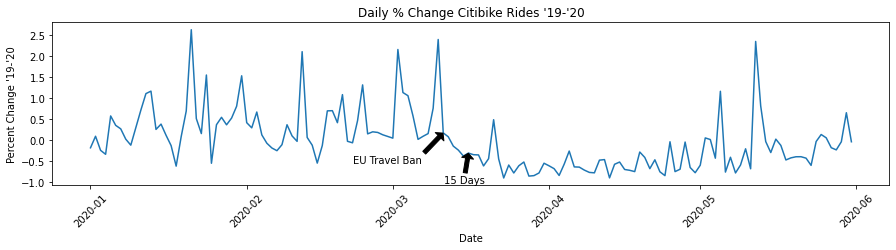

In [342]:
import matplotlib.dates as mdates

months = mdates.DateFormatter('%M')

#15 days to slow spread announcement date
social_dist_date_index = x_axis_days[x_axis_days=="2020-03-16"].index
travel_ban_date_index = x_axis_days[x_axis_days=="2020-03-11"].index

plt.figure(figsize=[15,3])

ax.xaxis.set_major_formatter(months)
plt.xticks(rotation=45)


#Annotate 15 days to slow the spread
plt.annotate(s="15 Days",xy=(x_axis_days[social_dist_date_index],bike_2019_2020_daily_pct_diff['PNCT_CHANGE_19_20'][social_dist_date_index]),
             xycoords='data',
             xytext=(-24,-30),
              textcoords="offset points",
             arrowprops=dict(facecolor='black', shrink=0.01, headlength=5, ))

#Annotate EU Travel Ban 
plt.annotate(s="EU Travel Ban",
    xy=(
    x_axis_days[travel_ban_date_index],bike_2019_2020_daily_pct_diff['PNCT_CHANGE_19_20'][travel_ban_date_index]),
    xytext=(-90,-30),
    xycoords='data',
    textcoords="offset points",
    arrowprops=dict(facecolor='black', shrink=0.01, headlength=5, ))


plt.title("Daily % Change Citibike Rides '19-'20")
plt.xlabel('Date')
plt.ylabel("Percent Change '19-'20")



plt.plot(x_axis_days,bike_2019_2020_daily_pct_diff['PNCT_CHANGE_19_20'])

# Get MTA Station Coordinates

In [ ]:
# Get the unique list of Stations 

station_info_df = pd.read_csv("data/stations.txt")
station_info_df_small = station_info_df[['Stop Name','GTFS Latitude','GTFS Longitude']]
station_info_df_small = station_info_df_small.drop_duplicates(subset="Stop Name")
station_info_df

In [ ]:
station_info_df.head()

In [ ]:
station_info_df[station_info_df["Stop Name"]=='WTC Cortlandt']

In [ ]:

print(f'{station_info_df_small.shape} Shape of Station info data frame')
station_info_df_small.head()

In [ ]:
#create dictionary of stations and their latitudes and longitude


station_info_dict={d['Stop Name']: (d['GTFS Latitude'],d['GTFS Longitude']) for d in station_info_df_small.to_dict(orient='records')}

#Look in the dictionary
print(f'Some Keys of this dictionary {list(station_info_dict.keys())[:5]}\n')

print(f'Some Values of this dictionary {list(station_info_dict.values())[:5]}')




In [ ]:
station_info_df.head()

In [ ]:
#create function to find_closest mta station
def find_closest_mta_station(latitude,longitude):
    station_distances =  {mta_station:great_circle(station_info_dict[mta_station],(latitude,longitude)).miles for mta_station in station_info_dict} 
    min_station = min(station_distances,key=station_distances.get)
    return min_station
    







In [ ]:
#create unique starting and ending bike stations df so we can find the closest MTA stations more quickly

unique_bike_stations_df_2019_start = bike_2019_df.drop_duplicates(subset=["start_station_name"])
unique_bike_stations_df_2019_end = bike_2019_df.drop_duplicates(subset=["end_station_name"])

unique_bike_stations_df_2020_start = bike_2020_df.drop_duplicates(subset=["start_station_name"])
unique_bike_stations_df_2020_end = bike_2020_df.drop_duplicates(subset=["end_station_name"])


unique_bike_stations_df_2019_start = unique_bike_stations_df_2019_start[['start_station_name','start_station_latitude','start_station_longitude']]
unique_bike_stations_df_2019_end = unique_bike_stations_df_2019_end[['end_station_name','end_station_latitude','end_station_longitude']]

unique_bike_stations_df_2020_start = unique_bike_stations_df_2020_start[['start_station_name','start_station_latitude','start_station_longitude']]
unique_bike_stations_df_2020_end = unique_bike_stations_df_2020_end[['end_station_name','end_station_latitude','end_station_longitude']]

In [ ]:
#unique bike stations in one df 
unique_bike_stations_start = pd.concat([unique_bike_stations_df_2019_start,unique_bike_stations_df_2020_start]).drop_duplicates(subset="start_station_name")

unique_bike_stations_end = pd.concat([unique_bike_stations_df_2019_end,unique_bike_stations_df_2020_end]).drop_duplicates(subset="end_station_name")

unique_bike_stations_start.head()
unique_bike_stations_end.head()

# Determine Bike Stations closest to MTA Stations

In [ ]:
unique_bike_stations_start['closest_mta_start']=unique_bike_stations_start.apply(lambda x:find_closest_mta_station(x['start_station_latitude'],x['start_station_longitude']),axis=1)
unique_bike_stations_end['closest_mta_end']=unique_bike_stations_end.apply(lambda x:find_closest_mta_station(x['end_station_latitude'],x['end_station_longitude']),axis=1)



In [ ]:
#We now have the end stations name with the closest mta station

print(unique_bike_stations_end.shape)
print(unique_bike_stations_end.closest_mta_end.nunique())
unique_bike_stations_end.head(25)


In [ ]:
print(unique_bike_stations_start.shape)
print(unique_bike_stations_start.closest_mta_start.nunique())

unique_bike_stations_start.head()

In [ ]:
#Add closested mta_station to bike df


In [ ]:
bike_2019_df_mta = bike_2019_df.merge(unique_bike_stations_start,on=["start_station_name","start_station_latitude",'start_station_longitude'],how="left")
bike_2019_df_mta = bike_2019_df_mta.merge(unique_bike_stations_end,on=["end_station_name","end_station_latitude",'end_station_longitude'],how="left")
print(bike_2019_df_mta.shape)
bike_2019_df_mta.head()

In [ ]:
bike_2020_df_mta = bike_2020_df.merge(unique_bike_stations_start,on=["start_station_name","start_station_latitude",'start_station_longitude'],how="left")
bike_2020_df_mta = bike_2020_df_mta.merge(unique_bike_stations_end,on=["end_station_name","end_station_latitude",'end_station_longitude'],how="left")
print(bike_2020_df_mta.shape)
bike_2020_df_mta.head()

# Create JANUARY - MAY 2019,2020 MTA Data Frame

In [ ]:


#Get 2019,2020 MTA into dataframes

df_list_2020=[]
for filename in glob.iglob('data/turnstile_mta/2020/**.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_list_2020.append(pd.read_csv(filename))
        
        
df_list_2019=[]
for filename in glob.iglob('data/turnstile_mta/2019/**.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_list_2019.append(pd.read_csv(filename))
        




In [ ]:
# Create 2019,2020 dataframes
mta_2020_df = pd.concat(df_list_2020)
mta_2019_df = pd.concat(df_list_2019)



In [ ]:
print(mta_2020_df.shape)
mta_2020_df.head()


In [ ]:
print(mta_2019_df.shape)
mta_2019_df.head()


In [ ]:
#get rid of entries that are zero
mta_2019_df = mta_2019_df[mta_2019_df.ENTRIES > 0]
mta_2020_df = mta_2020_df[mta_2020_df.ENTRIES > 0]

print(f'{mta_2019_df.shape} MTA_2019 Shape')
print(f'{mta_2020_df.shape} MTA 2020 Shape')

In [ ]:
#create time columns for mta
mta_2019_df["DATE"] = pd.to_datetime(mta_2019_df["DATE"])
mta_2019_df["HOUR"] = pd.to_datetime(mta_2019_df["TIME"],format="%H:%M:%S").dt.hour
mta_2019_df["WEEK"] = mta_2019_df["DATE"].dt.week
mta_2019_df["MONTH"] = mta_2019_df["DATE"].dt.month

mta_2020_df["DATE"] = pd.to_datetime(mta_2020_df["DATE"])
mta_2020_df["HOUR"] = pd.to_datetime(mta_2020_df["TIME"],format="%H:%M:%S").dt.hour
mta_2020_df["WEEK"] = mta_2020_df["DATE"].dt.week
mta_2020_df["MONTH"] = mta_2020_df["DATE"].dt.month


In [ ]:
#exits columns title has many spaces after, make new column with correct name
mta_2019_df['EXITS']=mta_2019_df.iloc[:,10]
mta_2020_df['EXITS']=mta_2020_df.iloc[:,10]

mta_2019_df = mta_2019_df.drop(columns=mta_2019_df.columns.to_list()[10])
mta_2020_df = mta_2020_df.drop(columns=mta_2020_df.columns.to_list()[10])

# CitiBike / MTA map

In [ ]:
bike_2019_df_mta[['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']]

In [ ]:
#geo data frame with coordinates



#Get GeoSeries for 2019 Starting
bike_2019_geo_df_mta_start = geopandas.GeoDataFrame(
bike_2019_df_mta, geometry=geopandas.points_from_xy(bike_2019_df_mta.start_station_longitude, bike_2019_df_mta.start_station_latitude))

starting_bike_stations_2019 =  geopandas.GeoSeries(bike_2019_geo_df_mta_start.iloc[:,-1])

#Get Geo Series for 2019 Ending

bike_2019_geo_df_mta_end = geopandas.GeoDataFrame(
bike_2019_df_mta, geometry=geopandas.points_from_xy(bike_2019_df_mta.end_station_longitude, bike_2019_df_mta.end_station_latitude))


ending_bike_stations_2019 = geopandas.GeoSeries(bike_2019_geo_df_mta_end.iloc[:,-1])


#reproject  
bike_2019_geo_df_mta_start.crs = {'init' :'epsg:4326'}  
bike_2019_geo_df_mta_start = bike_2019_geo_df_mta_start.to_crs(epsg=3857)

bike_2019_geo_df_mta_end.crs = {'init' :'epsg:4326'}  
bike_2019_geo_df_mta_end = bike_2019_geo_df_mta_end.to_crs(epsg=3857)

In [ ]:
#Reproject Coordinate system so it matches our figure's projection system

starting_bike_stations_2019.crs = {'init' :'epsg:4326'}
starting_bike_stations_2019 = starting_bike_stations_2019.to_crs(epsg=3857)

ending_bike_stations_2019.crs = {'init' :'epsg:4326'}
ending_bike_stations_2019 = ending_bike_stations_2019.to_crs(epsg=3857)


In [ ]:
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))

df = df.to_crs(epsg=3857)

ax = df.plot(figsize=(8, 8), alpha=0.2, edgecolor='k')

starting_bike_stations_2019.plot(ax=ax,color="red",markersize=5.0,marker="^")
ending_bike_stations_2019.plot(ax=ax,color="blue",markersize=2.0,alpha=0.5,marker="v")

ctx.add_basemap(ax)

plt.show()


In [ ]:
gdf = geopandas.GeoDataFrame.from_file("data/shapefile/new_york")


gdf=gdf.to_crs(epsg=4326)

In [ ]:
nj_gdf = geopandas.GeoDataFrame.from_file("data/shapefile/new_jersey")

In [ ]:
nj_gdf = nj_gdf.to_crs(epsg=4326)




In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
gdf.plot(ax=ax,alpha=0.9,)

In [ ]:
df['ENTRIES_DIFF']=( df.groupby(['STATION_ID','UNIT','SCP'],as_index=False)['ENTRIES']
                           .transform(pd.Series.diff)['ENTRIES']
                       )
